In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import time

For starters recognize kite on a picture / frame

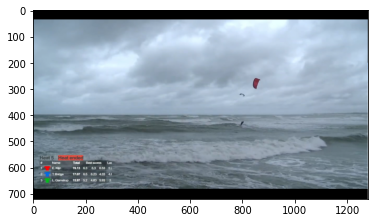

6.0 x: 150 y: 608
12
36.5 x: 203 y: 587
66
49.0 x: 231 y: 586
80
56.0 x: 261 y: 581
152
42.0 x: 237 y: 572
70
79.0 x: 794 y: 425
143
12.0 x: 851 y: 294
24
6.0 x: 860 y: 271
12
98.0 x: 840 y: 260
396


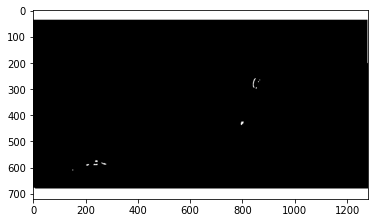

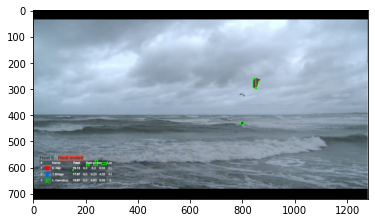

In [2]:
slika = cv.imread("projectData/CaptureHawai.PNG",1)
slika = cv.cvtColor(slika, cv.COLOR_BGR2RGB)
slika = cv.resize(slika, (1280, 720), interpolation=cv.INTER_CUBIC)
plt.imshow(slika)
plt.show()
# Plot version
slika_gray = cv.cvtColor(slika,cv.COLOR_RGB2GRAY)

thresh = cv.adaptiveThreshold(slika_gray, 5, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 11111, 1)
# _, thresh = cv.threshold(slika_gray, 40, 250, cv.THRESH_BINARY_INV)

kernel = np.ones((3, 3), np.uint8)
thresh = cv.dilate(thresh, kernel, iterations=1)


contours, hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

kites = []
humans = []
for cnt in contours:
    x, y, w, h = cv.boundingRect(cnt)
    rect_area = w*h
    rect_are = cv.contourArea(cnt)
    if 5 < rect_are < 2000:
        print(rect_are, "x:", x, "y:", y)
        print(rect_area)
        cv.rectangle(slika, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # RELEVANT FOR SIZE COMPARISON. SMALLER IS HUMAN LARGER IS KITE
        if rect_area < 20:
            humans.append({"area": rect_area, "x": x, "y": y, "width": w, "height": h})
        else:
            kites.append({"area": rect_area, "x": x, "y": y, "width": w, "height": h})
        # rectPoints = cv.boxPoints(rect)
        # rectPoints = np.int0(rectPoints)
        # cv.drawContours(slika, [rectPoints], -1, (0, 255, 0))

# cv.imwrite("Lab1_media/lab1_img.png", slika)

plt.imshow(thresh, cmap='gray')
plt.show()
plt.imshow(slika)
plt.show()

Define functions for detecting kite and tracking speed of movement

In [3]:
def get_kites_and_riders(img, draw_objects=False, only_riders=False):
    # Plot version
    img_gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    width, height = img_gray.shape
    # thresh = cv.adaptiveThreshold(img_gray, 5, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 11111, 1)
    _, thresh = cv.threshold(img_gray, 40, 250, cv.THRESH_BINARY_INV)

    kernel = np.ones((3, 3), np.uint8)
    thresh = cv.dilate(thresh, kernel, iterations=2)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

    kites = []
    humans = []
    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)
        rect_area = w*h
        rect_are = cv.contourArea(cnt)
        diff = height - y
        if y > height/2:
            rect_are = rect_are - (rect_are/ (np.power(1.5, diff)))
        else:
            diff = height/2 - y
            rect_are = rect_are + (diff/2)
        if 100 < rect_are < 2000:
            # print(rect_area)
            if draw_objects:
                cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
                # rect = cv.minAreaRect(cnt)
                # rectPoints = cv.boxPoints(rect)
                # rectPoints = np.int0(rectPoints)
                # cv.drawContours(slika, [rectPoints], -1, (0, 255, 0))
            # RELEVANT FOR SIZE COMPARISON. SMALLER IS HUMAN LARGER IS KITE
            if rect_area < 200:
                if only_riders:
                    if len(humans) > 0:
                        y_rel = humans[-1]['y']
                        if y + 20 < y_rel:
                            humans.append({"area": rect_area, "x": x, "y": y, "width": w, "height": h})
                else:
                    # Call ML model to classify human obj in that part of the frame
                    humans.append({"area": rect_area, "x": x, "y": y, "width": w, "height": h})
            else:
                # Call ML model to classify kite obj in that part of the frame
                kites.append({"area": rect_area, "x": x, "y": y, "width": w, "height": h})
    return kites, humans, img

def draw_flow(img, flow, step=16):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr


def draw_hsv(flow):

    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]

    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)

    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    return bgr

Then open camera( NOW JUST FILE ) and frame by frame check for kite and track it

In [6]:
lk_params = dict(winSize  = (15, 15),
                maxLevel = 1,
                criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 20, 0.03))

feature_params = dict(maxCorners = 200,
                    qualityLevel = 0.4,
                    minDistance = 10,
                    blockSize = 2)

SESSION_SARTED = False

trajectory_len = 20
detect_interval = 5
trajectory_groups = []
trajectories = []
frame_idx = 0
src = 'D:\\Sports\\Kitesurfing\\Media\\HawaiColdGamesLongest.mp4'
capture = cv.VideoCapture(src)
g = cv.waitKey(1)

suc, prev = capture.read()
prevgray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
draw_mask = prevgray
while 27 != g:
    # start time to calculate FPS
    fps_start = time.time()
    ret, frame = capture.read()
    if not ret:
        break
    img = frame.copy()
    img = cv.resize(img, (1280, 720), interpolation=cv.INTER_CUBIC)
    frame_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    h, w = frame_gray.shape

    # # Calculate optical flow for a sparse feature set using the iterative Lucas-Kanade Method
    # if len(trajectories) > 0:

    kites, riders, frame = get_kites_and_riders(img, draw_objects=True)

    """
        GET ALL MOVING POINTS AND FILTER ONLY THE ONES BELONGING TO THE RIDERS
        START MEASURING TIME AND DISTANCE
        TRY FOR SPEED
    """
    if SESSION_SARTED:
        cv.putText(img, 'START OF SESSION', (500, 50), cv.FONT_HERSHEY_PLAIN, 3, (0,0,255), 2)

    # Calculate optical flow for a sparse feature set using the iterative Lucas-Kanade Method
    if len(trajectories) > 0:
        img0, img1 = prev_gray, frame_gray
        p0 = np.float32([trajectory[-1] for trajectory in trajectories]).reshape(-1, 1, 2)
        p1, _st, _err = cv.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
        p0r, _st, _err = cv.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
        d = abs(p0-p0r).reshape(-1, 2).max(-1)
        good = d < 1

        new_trajectories = []

        # Get all the trajectories
        for trajectory, (x, y), good_flag in zip(trajectories, p1.reshape(-1, 2), good):
            if not good_flag:
                continue
            trajectory.append((x, y))
            # DO THIS EVERY 20 frames
            if len(trajectory_groups) > 0:
                create_group = True
                for trajectory_group in trajectory_groups:
                    last_x, last_y = trajectory_group[-1]
                    if last_x - 15 < x < last_x + 15 and last_y - 15 < y < last_y + 15:
                        first_x, first_y = trajectory_group[1]
                        dist = np.sqrt(np.power((first_x-last_x), 2) + np.power((first_y-last_y), 2))
                        dist_new = np.sqrt(np.power((first_x-x), 2) + np.power((first_y-y), 2))
                        if dist_new < dist:
                            if dist > w / 3:
                                t = time.time() - trajectory_group[0]
                                # print("Traveling time :", t)
                                travel_speed = dist / t
                                # print(travel_speed)
                                if travel_speed > 5:
                                    if not SESSION_SARTED:
                                        SESSION_SARTED = True
                                        print("START OF SESSION")
                                        cv.putText(img, 'START OF SESSION', (500, 50), cv.FONT_HERSHEY_PLAIN, 3, (0,0,255), 2)
                            if dist_new - dist > 2:
                                trajectory_group = [time.time(), (x, y)]
                                create_group = False
                                break
                        trajectory_group.append((x, y))
                        create_group = False
                        break
                if create_group:
                    trajectory_groups.append([time.time(), (x, y)])
            else:
                trajectory_groups.append([time.time(), (x, y)])
            if len(trajectory) > trajectory_len:
                del trajectory[0]
            new_trajectories.append(trajectory)
            # Newest detected point
            cv.circle(img, (int(x), int(y)), 2, (0, 0, 255), -1)

        trajectories = new_trajectories
        # print("TRAJECTORIES",[np.int32(trajectory) for trajectory in trajectories])
        # Draw all the trajectories
        cv.polylines(img, [np.int32(trajectory) for trajectory in trajectories], False, (0, 255, 0))
        cv.putText(img, 'track count: %d' % len(trajectories), (50, 50), cv.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2)


    # Update interval - When to update and detect new features
    if frame_idx % detect_interval == 0:
        draw_mask = np.zeros_like(frame_gray)
        draw_mask[:] = 255
        _, mask = cv.threshold(frame_gray, 40, 250, cv.THRESH_BINARY_INV)

        kernel = np.ones((3, 3), np.uint8)
        mask = cv.dilate(mask, kernel, iterations=1)

        # Lastest point in latest trajectory
        for x, y in [np.int32(trajectory[-1]) for trajectory in trajectories]:
            cv.circle(draw_mask, (x, y), 5, 0, -1)

        # Detect the good features to track
        p = cv.goodFeaturesToTrack(frame_gray, mask = mask, **feature_params)
        if p is not None:
            # If good features can be tracked - add that to the trajectories
            p_reshaped = np.float32(p).reshape(-1, 2)
            for x, y in p_reshaped:
                for rider_obj in riders:
                    x_rider = rider_obj['x']
                    y_rider = rider_obj['y']
                    height = rider_obj['height']
                    width = rider_obj['width']
                    if x_rider < x < x_rider + width and y_rider < y < y_rider + height:
                        point_added = False
                        trajectories.append([(x, y)])
                        break
    # print(trajectories)
    # if len(trajectories) > 1:
    #     break
    frame_idx += 1
    prev_gray = frame_gray

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # flow = cv.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # End time
    fps_end = time.time()
    # calculate the FPS for current frame detection
    fps = 1 / (fps_end-fps_start)
    # cv.putText(gray, str(fps), (5, 100), cv.FONT_HERSHEY_SIMPLEX, color=250, thickness=2, fontScale=1)
    cv.putText(frame, f'fps: {round(fps,2)}', (50, 100), cv.FONT_HERSHEY_SIMPLEX, color=250, thickness=2, fontScale=1)

    # cv.imshow('flow', draw_flow(gray, flow))

    # # IF KITES THEN TRACK MOVEMENT
    # if len(kites) > 0:
    #     continue
    #     # TRACK MOVEMENT of rider..
    # # plt.imshow(frame)
    # # plt.pause(.1)
    cv.imshow("Video", frame)
    cv.imshow('Mask', draw_mask)
    capturedPhoto = frame

    # for trajectory_group in trajectory_groups:


    g = cv.waitKey(10)

cv.destroyAllWindows()
capture.release()

START OF SESSION
